In [39]:
# Libraries used for gathering the data
import requests 
from bs4 import BeautifulSoup
import time
import random


# Libraries used for analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

In [40]:
## Data gathering
## This script webscrapes Public UFO Sighting Report Records from The National UFO Reporting Center data using BeautifulSoup and requests
## BeautifulSoup uses HTML tags to target where to take data from
## Caution when running this code, it scrapes thousands of records and takes hours to complete and will automatically create a csv file

# Make empty lists for fields to gather data in. number will be used to print the number link that scraper is scraping from
date = []
city = []
state = []
country = []
shape = []
duration = []
summary = []
full_text = []
number = 0



# Get URL and beautiful soup instance.
url = 'http://www.nuforc.org/webreports/ndxevent.html'
response = requests.get(url)
bs = BeautifulSoup(response.text, 'html.parser')
#Use Beautifulsoup bs.findall to find tags with 'a' which will find all clickable links on the page and save them to links variable
links = bs.find_all('a') 

# Creates loop for each link to gather all the data with the same HTML pattern.
# The first link is skipped because it is the home page link
for link in links[1:]:
    number = number + 1 #This gives a number in each link to keep track of the scraper's progress
    print("Loading..")
    
    # Time module is used to keep track how long it takes to scrape each link, this function starts the timer
    start_time = time.time()
    # Time module is used to give the program a wait time between 1-5 seconds per link as not give the website too many requests too fast
    time.sleep(random.randint(1, 5))
    
    # This if statement checks for href tag in each link, if it has it then that link is scraped
    if 'href'in link.attrs:
        url = ('http://www.nuforc.org/webreports/' + str(link.attrs['href']))
        response = requests.get(url)
        bs = BeautifulSoup(response.text, 'html.parser')
        
        # Searched for the tr tag which gives the data from the table on the web page.
        rows = bs.find_all('tr')
        
        # This loop goes through each row except the header row and appends each value of the web page table to it's specified list
        for row in rows[1:]:
            split_list = row.text.split('\n')
            date.append(split_list[1])
            city.append(split_list[2])
            state.append(split_list[3])
            country.append(split_list[4])
            shape.append(split_list[5])
            duration.append(split_list[6])
            summary.append(split_list[7])
    # time is ended and prints that the link is finished
    end_time = time.time()
    print('link ', str(number), ' finished in {} seconds'.format(end_time - start_time))
    

#After each link is scraped the data is put into a dictionary value
data = {'date' : date, 'city' : city, 'state' : state, 'country' : country, 'shape' : shape, 'duration' : duration, 'summary' : summary}

# It is then made into a dataframe object
df = pd.DataFrame(data)

# The data frame is saved as a csv file
df.to_csv('raw_sightings_data')

Loading..
link  1  finished in 4.244443893432617 seconds
Loading..
link  2  finished in 1.4425032138824463 seconds
Loading..
link  3  finished in 2.653001546859741 seconds
Loading..
link  4  finished in 3.448657751083374 seconds
Loading..
link  5  finished in 2.507981777191162 seconds
Loading..
link  6  finished in 2.0101940631866455 seconds
Loading..
link  7  finished in 1.404707431793213 seconds
Loading..
link  8  finished in 4.414514064788818 seconds
Loading..
link  9  finished in 4.243200302124023 seconds


In [41]:
## Start of Analysis
# Read in csv file
df = pd.read_csv('raw_sightings_data')

In [42]:
# Show snapshot of raw dataframe
df

,Unnamed: 0,date,city,state,country,shape,duration,summary
0,0,3/3/22 08:01,Phoenix,AZ,USA,Egg,NaN,No sound weird looking though it was helicopter
1,1,3/2/22 21:40,Lino Lakes,MN,USA,Sphere,3 minutes,Three bright spheres moving across sky.
2,2,3/2/22 18:19,Indianapolis,IN,USA,Cone,7 mins,Heard a high pitched ringing and turned around...
3,3,3/2/22 18:18,lexington,NE,USA,Cylinder,2 minutes,While waiting for a locksmith I observed an ob...
4,4,3/2/22 18:10,paw paw,MI,USA,Cone,10 seconds,Driving to work and saw bright light slow movi...
...,...,...,...,...,...,...,...,...
137422,137422,NaN,Graham,WA,USA,Disk,2 minutes,Driving west on 224th looked right saw large c...
137423,137423,NaN,NaN,NaN,USA,NaN,NaN,((HOAX??)) I work as a security guard in marc...
137424,137424,NaN,Edmond,OK,USA,NaN,NaN,((HOAX??)) 30 second bright red glowing fireb...
137425,137425,NaN,Richland,WA,USA,Sphere,10 min,Multiple sightings


In [43]:
## Data Cleaning
# Splits date column and saves the date to it's own column the time to it's own column
date_split = df['date'].str.split(' ', expand=True)
df['date'] = date_split[0]
df['time'] = date_split[1]

In [44]:
## Create function to clean text data using nltk stopwords and lemmatization
# Setup stopwords for english and setup lemmatizer
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stopword=set(stopwords.words('english'))

# create function
def clean(text):
    text = str(text).lower() # Turns text to lower case
    text = re.sub('\[.*?\]', '', text) # Gets rid of punctuation
    text = re.sub('https?://\S+|www\.\S+', '', text) # Gets rid of URL text
    text = re.sub('<.*?>+', '', text) # Gets rid of more punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # More punctuation
    text = re.sub('\n', '', text) # Eliminates new line text
    text = re.sub('’', '', text) # Eliminates apostrophies
    text = re.sub('\w*\d\w*', '', text) # eliminates numerical digits
    text = [word for word in text.split(' ') if word not in stopword] # List comprehension that eliminates stop words by splitting on any non stopword text text
    text=" ".join(text) #Joins seperated words
    text = [lemmatizer.lemmatize(word) for word in text.split(' ')] # Splits words again and lemmatizes them
    text=" ".join(text) # Joins together words again
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Applies clean function to summary column
df['summary'] = df['summary'].apply(clean)

In [46]:
# Makes new data from consisting of only 2018 data and up which ends at record 20988 because the data is already ordered by date
df = df.loc[:20988]

# Changes date data type to datetime format in order to perform functions with date data 
df.loc[:,'date'] = df.date.astype('datetime64')

# Created dataframe with only the total target three years needed for the analysis
# Filters between target dates then creates the dataframe
three_year_df = df[(df['date'] > '2018-09-14') & (df['date'] < '2021-09-16') & (df['country'] == 'USA')]
# Drops columns not needed for the analysis
three_year_df = three_year_df.drop(columns=['Unnamed: 0','city','duration','time'])

C:\Users\johns\AppData\Local\Temp\ipykernel_13752\1878788312.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'date'] = df.date.astype('datetime64')


In [47]:
# Gives snapshot of clean data set
three_year_df

,date,state,country,shape,summary
1570,2021-09-15,IN,USA,Circle,rounnd white light moving sw ne stopped hovere...
1571,2021-09-15,FL,USA,Light,evening dark partly cloudy listening live band...
1572,2021-09-15,CO,USA,Light,atmosphere entering tracer fire light
1573,2021-09-15,FL,USA,NaN,nuforc note witness provides detailed informa...
1574,2021-09-15,FL,USA,Changing,nuforc note witness provides detailed informa...
...,...,...,...,...,...
18461,2018-09-15,NJ,USA,Oval,saw bright oval light sky straight row flew a...
18462,2018-09-15,OH,USA,Circle,group bubblelike ufo seen ne ohio traveling nw
18463,2018-09-15,NY,USA,Triangle,saw triangular object green red line appeared ...
18464,2018-09-15,NJ,USA,Light,brilliant bright light brick nj


Before Covid Count:  8398

 After Covid Count:  7393


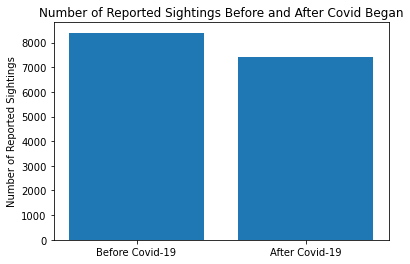

In [48]:
## Exploratory Data Analysis
# Creates new before and after covid data frames by using target dates as filters.
before_covid = three_year_df[three_year_df['date'] < '2020-03-15']
after_covid = three_year_df[three_year_df['date'] > '2020-03-15']

# Prints counts of each data set
print('Before Covid Count: ',before_covid['date'].count())
print('\n','After Covid Count: ',after_covid['date'].count())

# Plots bar chart of counts of each data set
plt.bar(['Before Covid-19', 'After Covid-19'],[before_covid['date'].count(),after_covid['date'].count()])

plt.ylabel('Number of Reported Sightings')
plt.title('Number of Reported Sightings Before and After Covid Began');

Before Covid Daily Mean:  15.352833638025594

 After Covid Daily Mean:  13.49087591240876


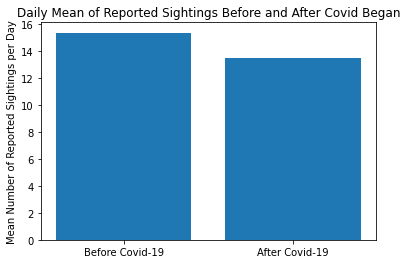

In [49]:
## Comparing Number of Report Instances Before and After Covid-19
# Uses groupby function to take counts of sightings for each individual day for both before and after covid time periods
before = before_covid.groupby('date')
before = before['date'].count()


after = after_covid.groupby('date')
after = after['date'].count()


# Prints the mean sightings per day for both data sets
print('Before Covid Daily Mean: ',before.mean())
print('\n','After Covid Daily Mean: ',after.mean())

# Creates bar plot of mean sightings per for both data sets
plt.bar(['Before Covid-19', 'After Covid-19'],[before.mean(),after.mean()])

plt.ylabel('Mean Number of Reported Sightings per Day')
plt.title('Daily Mean of Reported Sightings Before and After Covid Began');

In [50]:
# Creates hypothesis test for Mann-Whitney U test 
stat, p = mannwhitneyu(before, after)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interpret the test
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=173661.500, p=0.000
Different distribution (reject H0)


In [51]:
# This shows the actual p value since the test shows it as zero
p

5.34918254858708e-06

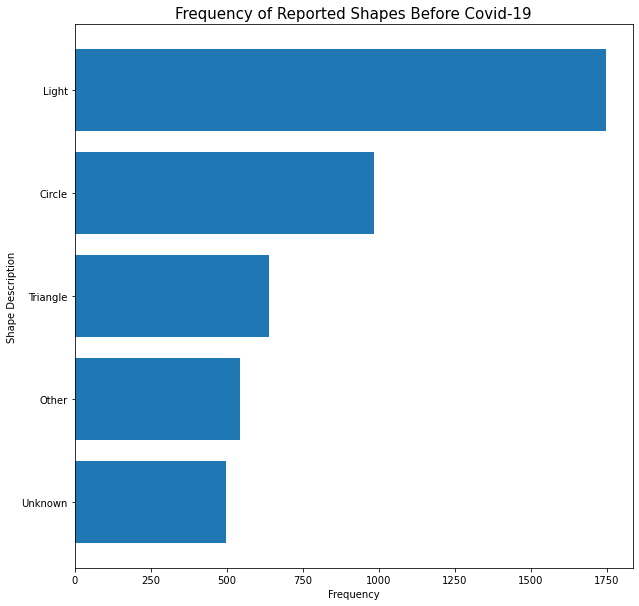

In [52]:
## Comparing Reported Shapes
# Prints Horizontal bar chart of the top 5 shapes reported

plt.figure(figsize = (10,10))

# Takes the value counts of the shape column and sorts them by ascending
y = before_covid['shape'].value_counts(sort=True, ascending=True)
# this does the same but only the index so the names show up as the x value instead of the actual value
x = before_covid['shape'].value_counts(sort=True, ascending=True).index

# The chart is plotted by taking both these x and y values made and taking the last 5 in the list
# This makes it so the the highest values are on top on the graph
plt.barh(x[-5:], y[-5:])
plt.title('Frequency of Reported Shapes Before Covid-19', fontsize = 15)
plt.xlabel('Frequency')
plt.ylabel('Shape Description');

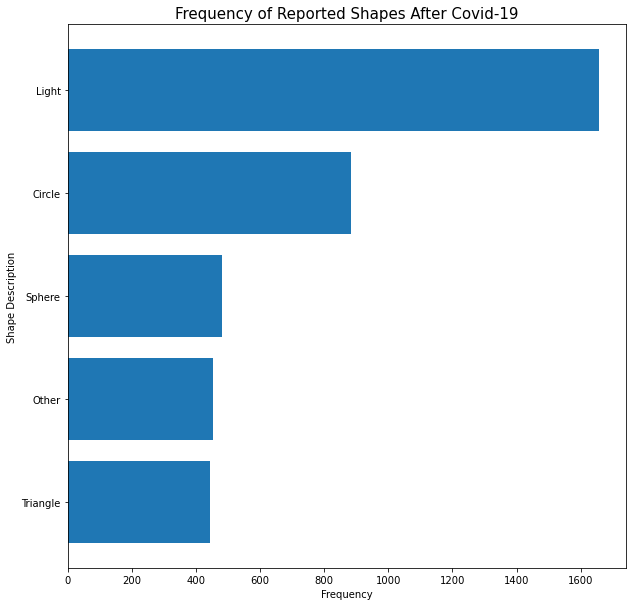

In [53]:
# This code does the same but for After Covid data

plt.figure(figsize = (10,10))

y = after_covid['shape'].value_counts(sort=True, ascending=True)
x = after_covid['shape'].value_counts(sort=True, ascending=True).index
plt.barh(x[-5:], y[-5:])
plt.title('Frequency of Reported Shapes After Covid-19',fontsize = 15)
plt.xlabel('Frequency')
plt.ylabel('Shape Description');

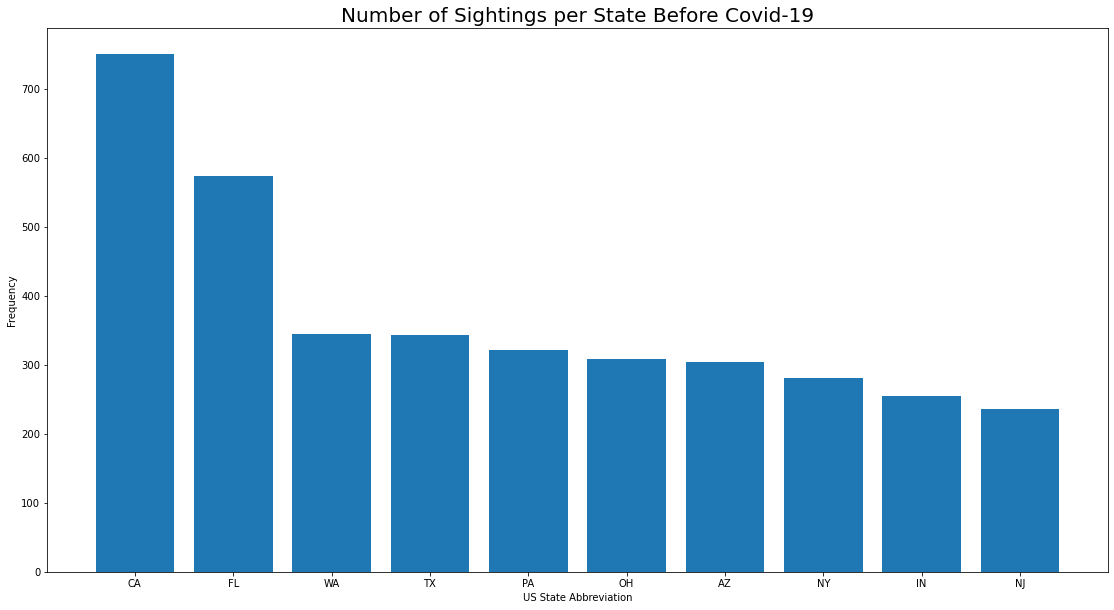

In [54]:
## Comparing Sights per State
# Plots bar chart for the states with the top 10 number of sightings in the same method as the previous charts
# Before covid chart

plt.figure(figsize = (19,10))

y = before_covid['state'].value_counts().values
x = before_covid['state'].value_counts().index
plt.bar(x[0:10], y[0:10])
plt.title('Number of Sightings per State Before Covid-19', fontsize = 20)
plt.xlabel('US State Abbreviation')
plt.ylabel('Frequency');

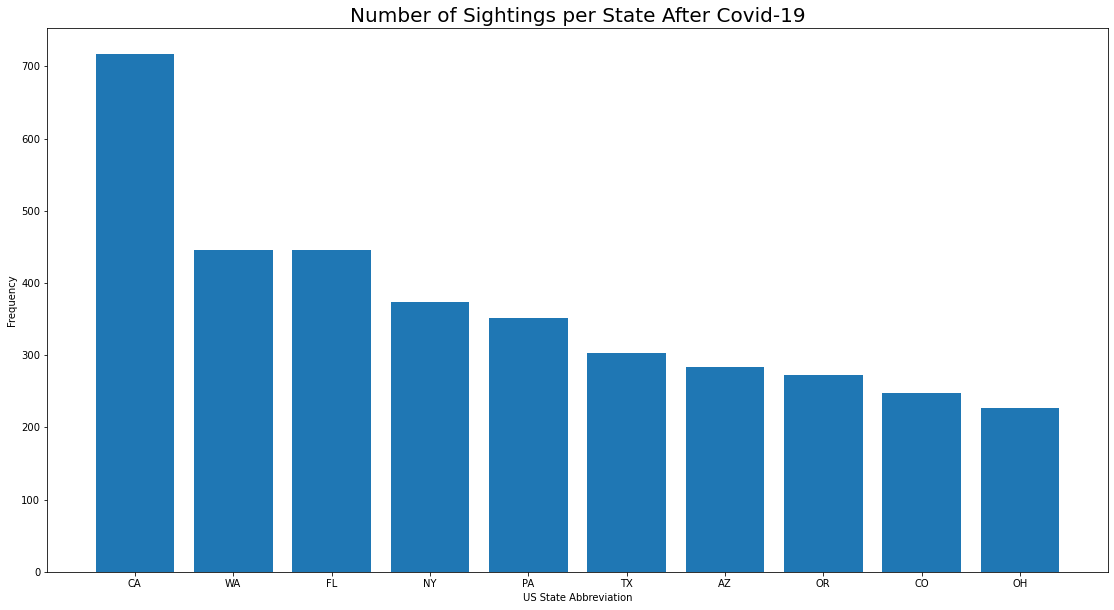

In [55]:
# After covid chart

plt.figure(figsize = (19,10))

y = after_covid['state'].value_counts().values
x = after_covid['state'].value_counts().index
plt.bar(x[0:10], y[0:10])
plt.title('Number of Sightings per State After Covid-19', fontsize = 20)
plt.xlabel('US State Abbreviation')
plt.ylabel('Frequency');

## Sentiment Analysis

In [56]:
## Sentiment Analysis 
# First uses Lambda function with textblob to get sentiment score for every comment and only the seniment score value [0] and creates a DataFrame column for it
# Then sentiment categories are made with the sentiment column by taking <0 score as negative, 0 as neutral and >0 as positive and turning into a DataFrame column
before_covid['sentiment'] = before_covid['summary'].apply(lambda i: TextBlob(str(i)).sentiment[0])
before_covid['sentiment_category'] = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in before_covid['sentiment']]


after_covid['sentiment'] = after_covid['summary'].apply(lambda i: TextBlob(str(i)).sentiment[0])
after_covid['sentiment_category'] = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in after_covid['sentiment']]

C:\Users\johns\AppData\Local\Temp\ipykernel_13752\221184000.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_covid['sentiment'] = before_covid['summary'].apply(lambda i: TextBlob(str(i)).sentiment[0])
C:\Users\johns\AppData\Local\Temp\ipykernel_13752\221184000.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_covid['sentiment_category'] = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in before_covid['sentiment']]
C:\Users\johns\AppData\Local\Temp\ipykernel

In [57]:
# Gives snapshot of data frame to show an example of how the data looks after sentiment analysis
before_covid

,date,state,country,shape,summary,sentiment,sentiment_category
9527,2020-03-14,TX,USA,Rectangle,cube shaped object silently glide neighborhood...,0.000000,neutral
9528,2020-03-14,MT,USA,Light,mysterious light sky looked like something sho...,0.250000,positive
9529,2020-03-14,WI,USA,Other,sky clear observed white starlike object weste...,0.033333,positive
9530,2020-03-14,PA,USA,Sphere,bright circle star like object,0.700000,positive
9532,2020-03-14,MN,USA,Light,white light moving fast medilia minnesota spa...,0.200000,positive
...,...,...,...,...,...,...,...
18461,2018-09-15,NJ,USA,Oval,saw bright oval light sky straight row flew a...,0.325000,positive
18462,2018-09-15,OH,USA,Circle,group bubblelike ufo seen ne ohio traveling nw,0.000000,neutral
18463,2018-09-15,NY,USA,Triangle,saw triangular object green red line appeared ...,-0.100000,negative
18464,2018-09-15,NJ,USA,Light,brilliant bright light brick nj,0.666667,positive


Count of Before Covid Summaries by Sentiment Category: 

positive    5029
neutral     2451
negative     918
Name: sentiment_category, dtype: int64


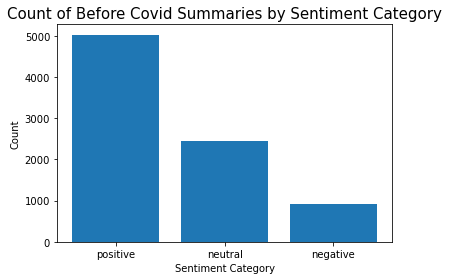

In [58]:
## Sentiment Categories
# Gets value counts of sentiment category column as a dictionary type object
before_cats = before_covid['sentiment_category'].value_counts()

# Prints that printout
print('Count of Before Covid Summaries by Sentiment Category:','\n')
print(before_cats)

# Plots bar chart of x as keys of dictionary obect and y as values of the object
plt.bar(before_cats.keys(),before_cats.values)

plt.title('Count of Before Covid Summaries by Sentiment Category', fontsize = 15)
plt.xlabel('Sentiment Category')
plt.ylabel('Count');

Count of After Covid Summaries by Sentiment Category: 

positive    4194
neutral     2369
negative     830
Name: sentiment_category, dtype: int64


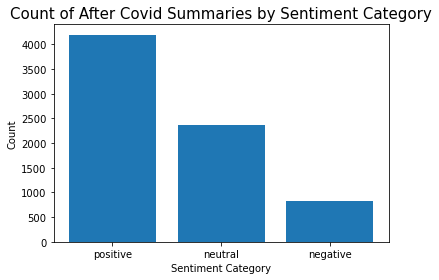

In [59]:
# Gets value counts of sentiment category column as a dictionary type object
after_cats = after_covid['sentiment_category'].value_counts()

# Prints that printout
print('Count of After Covid Summaries by Sentiment Category:','\n')
print(after_cats)

# Plots bar chart of x as keys of dictionary obect and y as values of the object
plt.bar(after_cats.keys(),after_cats.values)

plt.title('Count of After Covid Summaries by Sentiment Category', fontsize = 15)
plt.xlabel('Sentiment Category')
plt.ylabel('Count');

Before Covid mean of sentiment scores is:  0.14177733626496727

 After Covid mean of sentiment scores is:  0.1333834429339673


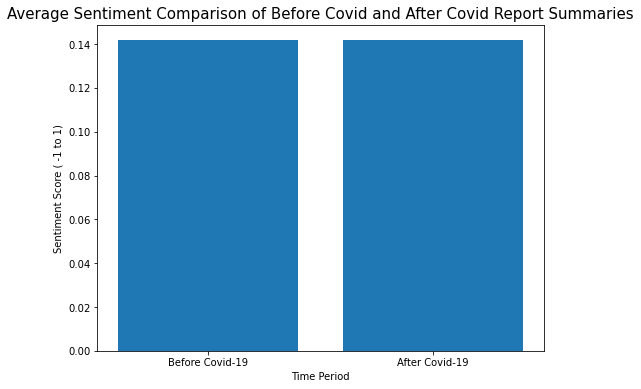

In [62]:
## Comparing Average Sentiment 

# Prints means of sentiment score for before and after covid summaries
print("Before Covid mean of sentiment scores is: ",before_covid['sentiment'].mean())
print("\n","After Covid mean of sentiment scores is: ",after_covid['sentiment'].mean())

# Creates bar chart for comparison of means
plt.figure(figsize=(8,6))

plt.bar(['Before Covid-19', 'After Covid-19'],[before_covid['sentiment'].mean(),before_covid['sentiment'].mean()])

plt.title('Average Sentiment Comparison of Before Covid and After Covid Report Summaries', fontsize = 15)
plt.xlabel('Time Period')
plt.ylabel('Sentiment Score ( -1 to 1)');

In [61]:
# Creates hypothesis test for Mann-Whitney U test 
stat, p = mannwhitneyu(before_covid['sentiment'], after_covid['sentiment'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interpret the test
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=31998559.000, p=0.001
Different distribution (reject H0)
